In [111]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import contextily as cx
import descartes

# Data curation
## Importing and wrangling spatial data

In [110]:
data = geopandas.read_file("data/metro-data2.geojson")
sdf = geopandas.GeoDataFrame(data)

#Select only the columns of interest
sdf = sdf[['HMGNS_LNK_', 'geometry']]

#Change projection and rename a column
sdf = sdf.to_crs(epsg=7899)
sdf.columns = ["HMGNS_LNK_ID", "geometry"]

#Lines have duplicates (each for 2 sides of the road) - we're keeping only one
sdf = sdf.drop_duplicates(subset="HMGNS_LNK_ID", keep="first")

#sort by ID
sdf = sdf.sort_values("HMGNS_LNK_ID")
print(sdf.head())

      HMGNS_LNK_ID                                           geometry
179              2  MULTILINESTRING ((2512268.212 2400819.746, 251...
547              9  MULTILINESTRING ((2521723.707 2398784.886, 252...
2813            25  MULTILINESTRING ((2497597.919 2404263.059, 249...
363             28  MULTILINESTRING ((2490757.167 2406179.544, 249...
327             30  MULTILINESTRING ((2502286.062 2399884.413, 250...


## Importing and cleaning data on traffic volume

In [109]:
dataset = pd.read_csv('data/TYPICAL_HOURLY_VOLUME_DATA.csv')

#Dropping columns of no interest
dataset = dataset.drop(['HMGNS_FLOW_ID', 'HMGNS_LNK_DESC', 'FLOW', 'COUNT_TYPE'], axis=1)
#Selecting workdays' data
dataset = dataset[dataset['PERIOD_TYPE']=='SCHOOL TERM/NORMAL']

#Renaming the 'hours' columns to be able to sort them from 0 to 23
dataset = dataset.rename(columns={"0:00": "0", "1:00": "1", "2:00": "2", "3:00": "3", "4:00": "4", "5:00": "5", "6:00": "6", "7:00": "7", "8:00": "8", "9:00": "9", "10:00": "10", "11:00": "11", "12:00": "12", "13:00": "13", "14:00": "14", "15:00": "15", "16:00": "16", "17:00": "17", "18:00": "18", "19:00": "19", "20:00": "20", "21:00": "21", "22:00": "22", "23:00": "23"}, errors="raise")
dataset = dataset.drop(['PERIOD_TYPE'], axis=1)

#Melting the data to make it long
dataset = dataset.melt(id_vars=['HMGNS_LNK_ID','DOW'], value_vars=dataset.iloc[:,2:27], var_name='Hour', value_name='Value')
dataset['Hour'] = pd.to_numeric(dataset['Hour'])

#Lines have duplicates (each for 2 sides of the road) - we're keeping only one
dataset = dataset.drop_duplicates(subset=["HMGNS_LNK_ID",'DOW','Hour'], keep="first")

#Sorting by Road ID, Day of week and Hour
dataset = dataset.sort_values(["HMGNS_LNK_ID",'DOW','Hour'])

#Normalising the traffic volume between 0 and 3 in order to plot it as linewidth
dataset['Normalised Value']=(dataset['Value']-dataset['Value'].min())/(dataset['Value'].max()-dataset['Value'].min())
dataset['Normalised Value']=5*dataset['Normalised Value']
print(dataset.head())

        HMGNS_LNK_ID  DOW  Hour  Value  Normalised Value
1974               2    1     0    886          0.408446
77023              2    1     1    489          0.225429
152072             2    1     2    335          0.154435
227121             2    1     3    317          0.146137
302170             2    1     4    468          0.215748


### Combining spatial data with the traffic volume data by road ID


In [107]:
sdf = sdf.to_crs(epsg=3857)
df = sdf.merge(dataset, on="HMGNS_LNK_ID", how="right")

#Sorting by Road ID, Day of week and Hour
df = df.sort_values(["HMGNS_LNK_ID", 'DOW', 'Hour'])

print(df.head())

   HMGNS_LNK_ID                                           geometry  DOW  Hour  \
0             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1     0   
1             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1     1   
2             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1     2   
3             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1     3   
4             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1     4   

   Value  Normalised Value  
0    886          0.408446  
1    489          0.225429  
2    335          0.154435  
3    317          0.146137  
4    468          0.215748  


## Plotting

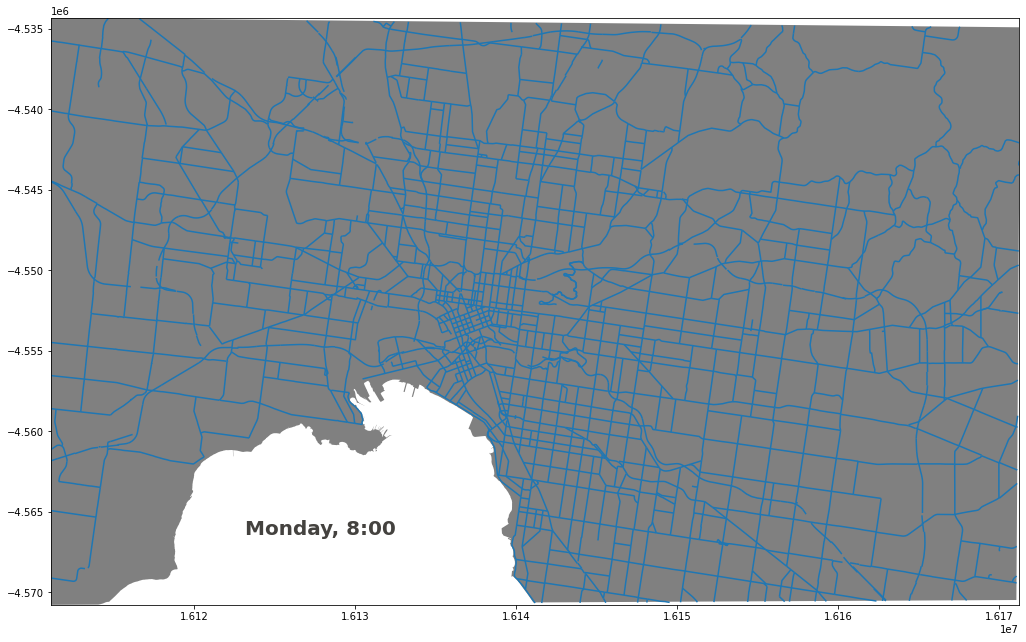

In [108]:
basemap = geopandas.read_file("data/land_basemap.geojson")
basemap = basemap.to_crs(epsg=3857)

fig, ax = plt.subplots(1,figsize=(19.2, 10.8))
ax.margins(-0.001,-0.0001)
sdf.plot(ax=ax, zorder = 2)
#cx.add_basemap(ax, source=cx.providers.nlmaps.grijs)
plt.annotate('Monday, 8:00', xy=(0.2, 0.12), xycoords='axes fraction', c="#44423f", fontfamily="sans-serif", fontsize=20, weight = 'semibold')
basemap.plot(ax=ax, color="gray", zorder = 1)
plt.show()

In [98]:
days_ow = {1:'Monday', 2: 'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
print(days_ow[5])

for dow, day_gdf in df.groupby("DOW"):
    today = days_ow[dow]
    for hour, day_hour_gdf in day_gdf.groupby("Hour"):
        #fig, ax = plt.subplots(1)
        fig, ax = plt.subplots(1, figsize=(19.2, 10.8))
        ax.margins(0)
        print(f"Doing dow={dow}, hour={hour}")
        sdf.plot(ax=ax, linewidth=0.2, color = "#e7e7de", zorder=2)
        day_hour_gdf.plot(ax=ax, linewidth=day_hour_gdf['Normalised Value'], color = "#e7e7de", zorder=3)
        basemap.plot(ax=ax, color="#0f3057", zorder = 1)
        plt.annotate("{}, {}:00".format(today, hour), xy=(0.2, 0.12), xycoords='axes fraction', c="#e0d8cc", fontfamily="sans-serif", fontsize=20, weight = 'semibold')
        ax.margins(-0.03,-0.03)
        plt.axis('off')
        plt.savefig("day{}_hour{}.png".format(dow, hour), dpi = 300, facecolor='#00587a', bbox_inches='tight')
        plt.close()

Friday
Doing dow=1, hour=0
Doing dow=1, hour=1
Doing dow=1, hour=2
Doing dow=1, hour=3
Doing dow=1, hour=4
Doing dow=1, hour=5
Doing dow=1, hour=6
Doing dow=1, hour=7
Doing dow=1, hour=8
Doing dow=1, hour=9
Doing dow=1, hour=10
Doing dow=1, hour=11
Doing dow=1, hour=12
Doing dow=1, hour=13
Doing dow=1, hour=14
Doing dow=1, hour=15
Doing dow=1, hour=16
Doing dow=1, hour=17
Doing dow=1, hour=18
Doing dow=1, hour=19
Doing dow=1, hour=20
Doing dow=1, hour=21
Doing dow=1, hour=22
Doing dow=1, hour=23
Doing dow=2, hour=0
Doing dow=2, hour=1
Doing dow=2, hour=2
Doing dow=2, hour=3
Doing dow=2, hour=4
Doing dow=2, hour=5
Doing dow=2, hour=6
Doing dow=2, hour=7
Doing dow=2, hour=8
Doing dow=2, hour=9
Doing dow=2, hour=10
Doing dow=2, hour=11
Doing dow=2, hour=12
Doing dow=2, hour=13
Doing dow=2, hour=14
Doing dow=2, hour=15
Doing dow=2, hour=16
Doing dow=2, hour=17
Doing dow=2, hour=18
Doing dow=2, hour=19
Doing dow=2, hour=20
Doing dow=2, hour=21
Doing dow=2, hour=22
Doing dow=2, hour=23
Doing

In [105]:
#different colour palette
days_ow = {1:'Monday', 2: 'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
print(days_ow[5])

for dow, day_gdf in df.groupby("DOW"):
    today = days_ow[dow]
    for hour, day_hour_gdf in day_gdf.groupby("Hour"):
        #fig, ax = plt.subplots(1)
        fig, ax = plt.subplots(1, figsize=(19.2, 10.8))
        ax.margins(0)
        print(f"Doing dow={dow}, hour={hour}")
        sdf.plot(ax=ax, linewidth=0.2, color = "#fcdab7", zorder=2)
        day_hour_gdf.plot(ax=ax, linewidth=day_hour_gdf['Normalised Value'], color = "#fcdab7", zorder=3)
        basemap.plot(ax=ax, color="#133b5c", zorder = 1)
        plt.annotate("{}, {}:00".format(today, hour), xy=(0.2, 0.12), xycoords='axes fraction', c="#e0d8cc", fontfamily="sans-serif", fontsize=20, weight = 'semibold')
        ax.margins(-0.03,-0.03)
        plt.axis('off')
        plt.savefig("col_day{}_hour{}.png".format(dow, hour), dpi = 300, facecolor='#1d2d50', bbox_inches='tight')
        plt.close()

Friday
Doing dow=1, hour=0
Doing dow=1, hour=1
Doing dow=1, hour=2
Doing dow=1, hour=3
Doing dow=1, hour=4
Doing dow=1, hour=5
Doing dow=1, hour=6
Doing dow=1, hour=7
Doing dow=1, hour=8
Doing dow=1, hour=9
Doing dow=1, hour=10
Doing dow=1, hour=11
Doing dow=1, hour=12
Doing dow=1, hour=13
Doing dow=1, hour=14
Doing dow=1, hour=15
Doing dow=1, hour=16
Doing dow=1, hour=17
Doing dow=1, hour=18
Doing dow=1, hour=19
Doing dow=1, hour=20
Doing dow=1, hour=21
Doing dow=1, hour=22
Doing dow=1, hour=23
Doing dow=2, hour=0
Doing dow=2, hour=1
Doing dow=2, hour=2
Doing dow=2, hour=3
Doing dow=2, hour=4
Doing dow=2, hour=5
Doing dow=2, hour=6
Doing dow=2, hour=7
Doing dow=2, hour=8
Doing dow=2, hour=9
Doing dow=2, hour=10
Doing dow=2, hour=11
Doing dow=2, hour=12
Doing dow=2, hour=13
Doing dow=2, hour=14
Doing dow=2, hour=15
Doing dow=2, hour=16
Doing dow=2, hour=17
Doing dow=2, hour=18
Doing dow=2, hour=19
Doing dow=2, hour=20
Doing dow=2, hour=21
Doing dow=2, hour=22
Doing dow=2, hour=23
Doing

### Basemaps

In [101]:
print(cx.providers.keys())
print(cx.providers.nlmaps.keys())

dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])
dict_keys(['standaard', 'pastel', 'grijs', 'luchtfoto'])


### Additional tests

In [ ]:
#Old version
#hourly = pd.read_csv('TYPICAL_HOURLY_VOLUME_DATA.csv')
#Dropping columns of no interest
#hourly_dropped = hourly.drop(['HMGNS_FLOW_ID', 'HMGNS_LNK_DESC', 'FLOW', 'COUNT_TYPE', 'PERIOD_TYPE'], axis=1)
#Renaming the 'hours' columns to be able to sort them from 0 to 23
#hourly_dropped = hourly_dropped.rename(columns={"0:00": "0", "1:00": "1", "2:00": "2", "3:00": "3", "4:00": "4", "5:00": "5", "6:00": "6", "7:00": "7", "8:00": "8", "9:00": "9", "10:00": "10", "11:00": "11", "12:00": "12", "13:00": "13", "14:00": "14", "15:00": "15", "16:00": "16", "17:00": "17", "18:00": "18", "19:00": "19", "20:00": "20", "21:00": "21", "22:00": "22", "23:00": "23"}, errors="raise")
#Melting the data to make it long
#hourly_long = hourly_dropped.melt(id_vars=['HMGNS_LNK_ID','DOW'], value_vars=hourly_dropped.iloc[:,2:27], var_name='Hour', value_name='Value')
#hourly_long['Hour'] = pd.to_numeric(hourly_long['Hour'])
#sorted_df = hourly_long.sort_values(['HMGNS_LNK_ID','DOW','Hour'])
#print(sorted_df.head(5))
#Grouping by: road ID, Day of week and Hour and calculating average value of traffic volume for each
#grouped_multiple = hourly_long.groupby(['HMGNS_LNK_ID', 'DOW', 'Hour']).agg({'Value': 'mean'})
#grouped_multiple.columns = ['Average Value']
#grouped_multiple = grouped_multiple.reset_index()
#Sorting by Road ID, Day of week and Hour
#sorted_df = grouped_multiple.sort_values(["HMGNS_LNK_ID"])
#Normalising the traffic volume between 0 and 3 in order to plot it as linewidth
#dataset['Normalised Value']=(dataset['Value']-dataset['Value'].min())/(dataset['Value'].max()-dataset['Value'].min())
#dataset['Normalised Value']=4*dataset['Normalised Value']
#print(sorted_df.head(170))

In [63]:
#Old version
hourly = pd.read_csv('data/TYPICAL_HOURLY_VOLUME_DATA.csv')
#Dropping columns of no interest
hourly_dropped = hourly.drop(['HMGNS_FLOW_ID', 'HMGNS_LNK_DESC', 'FLOW', 'COUNT_TYPE', 'PERIOD_TYPE'], axis=1)
#Renaming the 'hours' columns to be able to sort them from 0 to 23
hourly_dropped = hourly_dropped.rename(columns={"0:00": "0", "1:00": "1", "2:00": "2", "3:00": "3", "4:00": "4", "5:00": "5", "6:00": "6", "7:00": "7", "8:00": "8", "9:00": "9", "10:00": "10", "11:00": "11", "12:00": "12", "13:00": "13", "14:00": "14", "15:00": "15", "16:00": "16", "17:00": "17", "18:00": "18", "19:00": "19", "20:00": "20", "21:00": "21", "22:00": "22", "23:00": "23"}, errors="raise")
#Melting the data to make it long
hourly_long = hourly_dropped.melt(id_vars=['HMGNS_LNK_ID','DOW'], value_vars=hourly_dropped.iloc[:,2:27], var_name='Hour', value_name='Value')
hourly_long['Hour'] = pd.to_numeric(hourly_long['Hour'])
sorted_df = hourly_long.sort_values(['HMGNS_LNK_ID','DOW','Hour'])
#print(sorted_df.head(5))
#Grouping by: road ID, Day of week and Hour and calculating average value of traffic volume for each
grouped_multiple = hourly_long.groupby(['HMGNS_LNK_ID', 'DOW', 'Hour']).agg({'Value': 'mean'})
grouped_multiple.columns = ['Average Value']
grouped_multiple = grouped_multiple.reset_index()
#Sorting by Road ID, Day of week and Hour
sorted_df = grouped_multiple.sort_values(["HMGNS_LNK_ID", "DOW", "Hour"])
#Normalising the traffic volume between 0 and 3 in order to plot it as linewidth
sorted_df['Normalised Value']=(sorted_df['Average Value']-sorted_df['Average Value'].min())/(sorted_df['Average Value'].max()-sorted_df['Average Value'].min())
sorted_df['Normalised Value']=4*sorted_df['Normalised Value']
old_df = sorted_df

data = geopandas.read_file("https://opendata.arcgis.com/datasets/5512df2ff41e4941bacf868053dbfba9_0.geojson")
data = data[data['RGN_LONG_NM'].isin(['METROPOLITAN SOUTH EAST REGION','METROPOLITAN NORTH WEST REGION'])]
sdf_old = geopandas.GeoDataFrame(data)

#Select only the columns of interest
sdf_old = sdf_old[['HMGNS_LNK_ID', 'geometry']]

#Change projection and rename a column
sdf_old = sdf_old.to_crs(epsg=3857)
sdf_old.columns = ["HMGNS_LNK_ID", "geometry"]

#Lines have duplicates (each for 2 sides of the road) - we're keeping only one
sdf_old = sdf_old.drop_duplicates(subset="HMGNS_LNK_ID", keep="first")

old_df = sdf_old.merge(old_df, on="HMGNS_LNK_ID", how="right")

print(old_df.head(170))

     HMGNS_LNK_ID                                           geometry  DOW  \
0               2  LINESTRING (16156852.414 -4564414.405, 1615700...    1   
1               2  LINESTRING (16156852.414 -4564414.405, 1615700...    1   
2               2  LINESTRING (16156852.414 -4564414.405, 1615700...    1   
3               2  LINESTRING (16156852.414 -4564414.405, 1615700...    1   
4               2  LINESTRING (16156852.414 -4564414.405, 1615700...    1   
..            ...                                                ...  ...   
165             2  LINESTRING (16156852.414 -4564414.405, 1615700...    7   
166             2  LINESTRING (16156852.414 -4564414.405, 1615700...    7   
167             2  LINESTRING (16156852.414 -4564414.405, 1615700...    7   
168            32  LINESTRING (16133142.477 -4542140.175, 1613309...    1   
169            32  LINESTRING (16133142.477 -4542140.175, 1613309...    1   

     Hour  Average Value  Normalised Value  
0       0     909.833333      

Doing dow=1, hour=0
Doing dow=1, hour=1
Doing dow=1, hour=2
Doing dow=1, hour=3
Doing dow=1, hour=4
Doing dow=1, hour=5
Doing dow=1, hour=6
Doing dow=1, hour=7
Doing dow=1, hour=8


KeyboardInterrupt: 

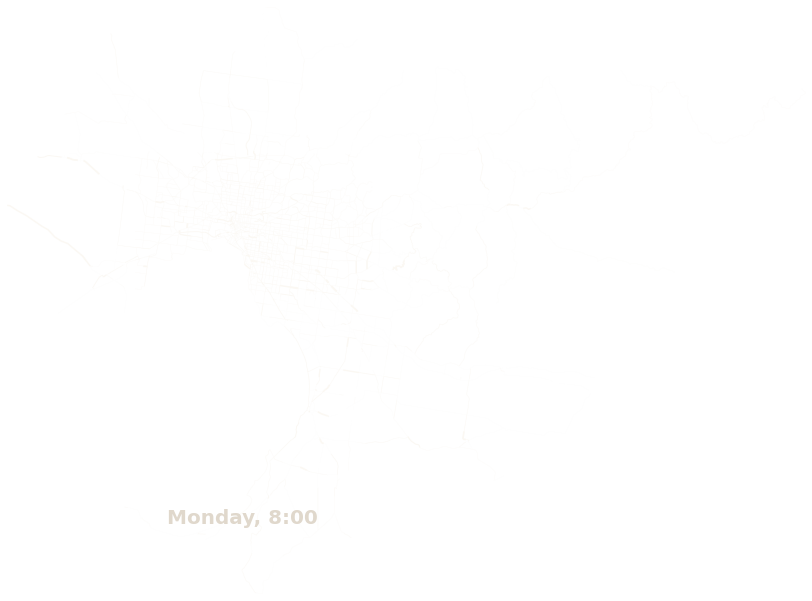

In [65]:
#Test plot
for dow, day_gdf in old_df.groupby("DOW"):
    today = days_ow[dow]
    for hour, day_hour_gdf in day_gdf.groupby("Hour"):
        #fig, ax = plt.subplots(1)
        fig, ax = plt.subplots(1, figsize=(19.2, 10.8))
        ax.margins(0)
        print(f"Doing dow={dow}, hour={hour}")
        sdf.plot(ax=ax, linewidth=0.2, color = "#FBF8F3")
        day_hour_gdf.plot(ax=ax, linewidth=day_hour_gdf['Normalised Value'], color = "#FBF8F3")
        plt.annotate("{}, {}:00".format(today, hour), xy=(0.2, 0.12), xycoords='axes fraction', c="#e0d8cc", fontfamily="sans-serif", fontsize=20, weight = 'semibold')
        plt.axis('off')
        plt.savefig("day{}_hour{}.png".format(dow, hour), dpi = 300, facecolor='#44423f', bbox_inches='tight')
        plt.close()